In [102]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


In [103]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [104]:
# Merge customer and transaction data
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
data = pd.merge(transactions, customers, on='CustomerID', how='left')

In [121]:
# Feature Engineering: Aggregate transaction data for each customer
customer_transactions = transactions.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'TransactionID': 'count',  # Number of transactions
    'TransactionDate': 'max'   # Latest transaction date
}).rename(columns={
    'Quantity': 'TotalQuantity',
    'TotalValue': 'TotalSpent',
    'TransactionID': 'TransactionCount',
    'TransactionDate': 'LastPurchaseDate'
})


In [125]:
# Convert 'TransactionDate' to datetime format
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Calculate Recency: Number of days since the last transaction for each customer
customer_transactions['Recency'] = (customer_transactions['LastPurchaseDate'].max() - customer_transactions['LastPurchaseDate']).dt.days


In [126]:
#Customer Lifetime Value (CLV):

customer_transactions['CLV'] = customer_transactions['TotalSpent'] * 12 / customer_transactions['Recency']



In [127]:
# Churn Likelihood: Introduce a churn likelihood score based on recency thresholds:

customer_transactions['ChurnLikelihood'] = np.where(customer_transactions['Recency'] > 180, 1, 0)


In [128]:
#Purchase Frequency: Average time between purchases:
customer_transactions['AvgDaysBetweenPurchases'] = customer_transactions['Recency'] / customer_transactions['TransactionCount']


In [129]:
# Calculate the Average Transaction Value for each customer
customer_transactions['AvgTransactionValue'] = customer_transactions['TotalSpent'] / customer_transactions['TransactionCount']


In [130]:
# Standardize the features: RFM + AvgTransactionValue
scaler = StandardScaler()
customer_transactions_scaled = scaler.fit_transform(customer_transactions[['Recency', 'TransactionCount', 'TotalSpent', 'AvgTransactionValue']])

# Convert the scaled data back to a DataFrame
customer_transactions_scaled = pd.DataFrame(customer_transactions_scaled, columns=['Recency', 'TransactionCount', 'TotalSpent', 'AvgTransactionValue'])


In [131]:

# Add customer profile information
customer_data = pd.merge(customer_transactions, customers, on='CustomerID', how='inner')

In [132]:
# Encode categorical data
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)


# Select features for clustering
features = ['TotalQuantity', 'TotalSpent', 'TransactionCount'] + [col for col in customer_data.columns if 'Region_' in col]
X = customer_data[features]


from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [133]:
# Find optimal number of clusters (2 to 10) using Davies-Bouldin Index
db_indices = []
silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    db_indices.append(davies_bouldin_score(X_scaled, labels))
    silhouette_scores.append(silhouette_score(X_scaled, labels))

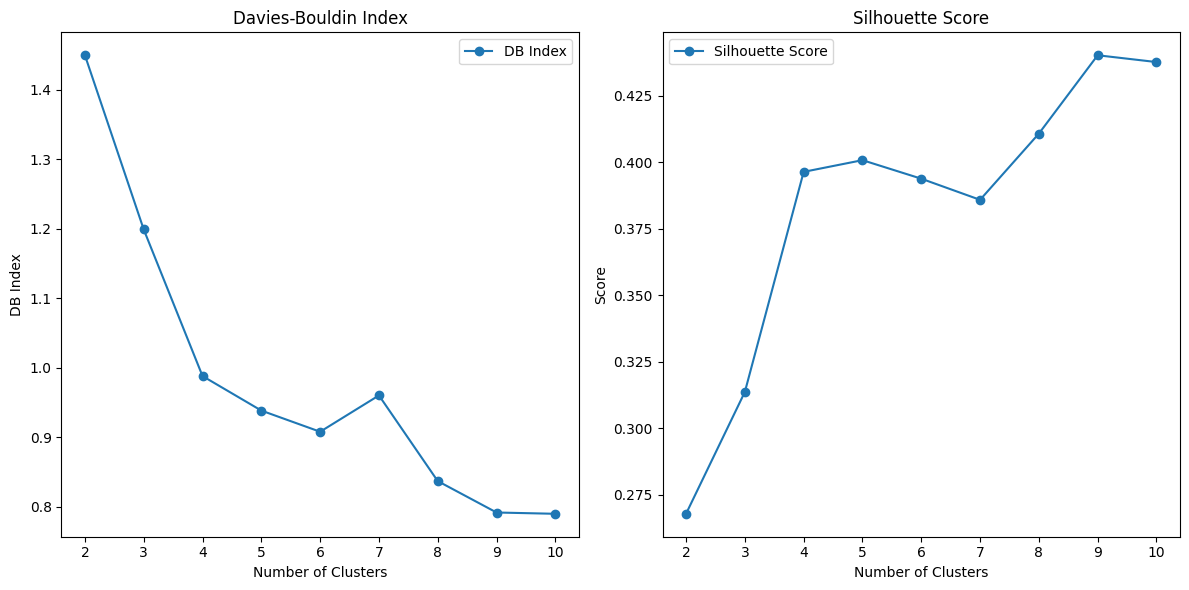

In [134]:
# Plot Davies-Bouldin Index and Silhouette Score
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, db_indices, marker='o', label='DB Index')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

In [135]:
# Choose optimal number of clusters (based on lowest DB Index)
optimal_k = k_values[np.argmin(db_indices)]
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 10


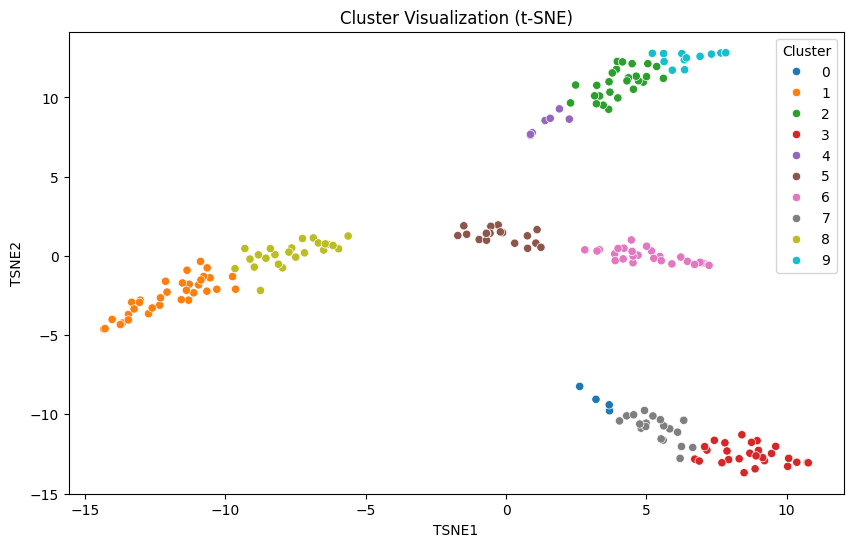

In [139]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_scaled)
customer_data['TSNE1'] = tsne_results[:, 0]
customer_data['TSNE2'] = tsne_results[:, 1]

# Perform KMeans clustering with optimal number of clusters and assign Cluster labels before plotting
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)
customer_data['Cluster'] = kmeans.labels_ # Assign cluster labels here

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x='TSNE1', y='TSNE2', hue='Cluster', palette='tab10')
plt.title('Cluster Visualization (t-SNE)')
plt.show()

In [140]:
cluster_summary = customer_data.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'TransactionCount': ['mean', 'median'],
    'TotalSpent': ['mean', 'median'],
    'AvgTransactionValue': ['mean', 'median']
})
print(cluster_summary)


            Recency        TransactionCount          TotalSpent            \
               mean median             mean median         mean    median   
Cluster                                                                     
0         19.750000   20.5         8.500000    8.5  6856.610000  5999.375   
1         72.742857   66.0         3.971429    4.0  2561.333143  2725.380   
2         75.230769   75.5         5.615385    5.0  3334.220385  3115.610   
3         86.370370   77.0         3.481481    3.0  2056.031481  2138.260   
4         35.857143   14.0         9.285714   10.0  6244.077143  5950.420   
5         58.444444   44.0         7.500000    8.0  5379.353889  5485.455   
6         87.346154   49.0         3.192308    3.0  2124.869231  2187.210   
7         71.263158   79.0         5.578947    6.0  4385.017895  4536.400   
8         48.916667   40.0         6.875000    7.0  5404.412500  5366.355   
9        129.923077   98.0         2.538462    3.0  1685.779231  1785.870   

In [141]:
# Report clustering metrics
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, customer_data['Cluster'])}")
print(f"Silhouette Score: {silhouette_score(X_scaled, customer_data['Cluster'])}")

# Save results
customer_data.to_csv('customer_segmentation_results.csv', index=False)

Davies-Bouldin Index: 0.79002838575684
Silhouette Score: 0.4376314340223128


In [142]:
# Perform KMeans clustering with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)
customer_data['Cluster'] = kmeans.labels_

In [143]:
cluster_summary = customer_data.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'TransactionCount': ['mean', 'median'],
    'TotalSpent': ['mean', 'median'],
    'AvgTransactionValue': ['mean', 'median']
})
print(cluster_summary)


            Recency        TransactionCount          TotalSpent            \
               mean median             mean median         mean    median   
Cluster                                                                     
0         19.750000   20.5         8.500000    8.5  6856.610000  5999.375   
1         72.742857   66.0         3.971429    4.0  2561.333143  2725.380   
2         75.230769   75.5         5.615385    5.0  3334.220385  3115.610   
3         86.370370   77.0         3.481481    3.0  2056.031481  2138.260   
4         35.857143   14.0         9.285714   10.0  6244.077143  5950.420   
5         58.444444   44.0         7.500000    8.0  5379.353889  5485.455   
6         87.346154   49.0         3.192308    3.0  2124.869231  2187.210   
7         71.263158   79.0         5.578947    6.0  4385.017895  4536.400   
8         48.916667   40.0         6.875000    7.0  5404.412500  5366.355   
9        129.923077   98.0         2.538462    3.0  1685.779231  1785.870   

In [144]:
# Report clustering metrics
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, customer_data['Cluster'])}")
print(f"Silhouette Score: {silhouette_score(X_scaled, customer_data['Cluster'])}")

# Save results
customer_data.to_csv('customer_segmentation_results.csv', index=False)

Davies-Bouldin Index: 0.79002838575684
Silhouette Score: 0.4376314340223128
